# Transformer Architecture and Machine Translation with the Transformer

In this notebook, you will understand the Transformer architecture introduced in [Vaswani et al., 2017], learn how to load a pretrained Transformer model in GluonNLP and translate a few sentences youself with the `BeamSearchTranslator`.

In [1]:
import random
import math
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import mxnet as mx
from mxnet import gluon, nd
from mxnet.gluon import nn
import gluonnlp as nlp
from utils import print_side_by_side

# Switch on Numpy compatible shape handling (eg. for arrays with shape 0; will be default in MXNet 2)
mx.set_np_shape(True)

ctx = mx.context.gpu(0) if mx.context.num_gpus() else mx.context.cpu()

%matplotlib inline

from matplotlib import pyplot as plt

# Attention Mechanism


In :numref:`chapter_seq2seq`, we encode the source sequence input information in the recurrent unit state and then pass it to the decoder to generate the target sequence. A token in the target sequence may closely relate to some tokens in the source sequence instead of the whole source sequence. For example, when translating "Hello world." to "Bonjour le monde.", "Bonjour" maps to "Hello" and "monde" maps to "world". In the seq2seq model, the decoder may implicitly select the corresponding information from the state passed by the decoder. The attention mechanism, however, makes this selection explicit.

Attention is a generalized pooling method with bias alignment over inputs. The core component in the attention mechanism is the attention layer, or called attention for simplicity. An input of the attention layer is called a query. For a query, the attention layer returns the output based on its memory, which is a set of key-value pairs. To be more specific, assume a query $\mathbf{q}\in\mathbb R^{d_q}$, and the memory contains $n$ key-value pairs, $(\mathbf{k}_1, \mathbf{v}_1), \ldots, (\mathbf{k}_n, \mathbf{v}_n)$, with $\mathbf{k}_i\in\mathbb R^{d_k}$, $\mathbf{v}_i\in\mathbb R^{d_v}$. The attention layer then returns an output $\mathbf o\in\mathbb R^{d_v}$ with the same shape as a value.

<center>
<img src="../img/attention.svg" width="33%"/>
</center>



To compute the output, we first assume there is a score function $\alpha$ which measures the similarity between the query and a key. Then we compute all $n$ scores $a_1, \ldots, a_n$ by

$$a_i = \alpha(\mathbf q, \mathbf k_i).$$

Next we use softmax to obtain the attention weights

$$b_1, \ldots, b_n = \textrm{softmax}(a_1, \ldots, a_n).$$

The output is then a weighted sum of the values

$$\mathbf o = \sum_{i=1}^n b_i \mathbf v_i.$$

Different choices of the score function lead to different attention layers. We will discuss two commonly used attention layers in the rest of this section. Before diving into the implementation, we first introduce a masked version of the softmax operator and explain a specialized dot operator `nd.batched_dot`.

## Enforcing Causality: Masked Softmax

<center>
<img src="../img/causal-attention.png" width="40%"/>
</center>

The masked softmax enables enforcing causality when computing attention weights.
It takes the attention scores and a mask as input and filters out masked scores when computing the attention weights.

In [2]:
attention_scores = nd.random.uniform(shape=(2,3,3))
mask = nd.ones(shape=(2,3,3))
mask[0, :, 2:] = 0
nlp.model.attention_cell._masked_softmax(nd, attention_scores, mask, attention_scores.dtype)


[[[0.488994   0.511006   0.        ]
  [0.56008387 0.43991613 0.        ]
  [0.42497858 0.57502145 0.        ]]

 [[0.35589045 0.36392704 0.28018245]
  [0.29034293 0.25239876 0.45725834]
  [0.21196374 0.5249825  0.26305377]]]
<NDArray 2x3x3 @cpu(0)>

Now we create two batches, and each batch has one query and 10 key-value pairs. 
We specify through `mask` that for the first batch, we will only pay attention to the first key-value pair, while for the second batch, we will check the first 6 key-value pairs. Therefore, though both batches have the same query and key-value pairs, we obtain different outputs.

## Computing Attention Weights: Dot Product Attention

The dot product assumes the query has the same dimension as the keys, namely $\mathbf q, \mathbf k_i \in\mathbb R^d$ for all $i$. It computes the score by an inner product between the query and a key, often then divided by $\sqrt{d}$ to make the scores less sensitive to the dimension $d$. In other words,

$$\alpha(\mathbf q, \mathbf k) = \langle \mathbf q, \mathbf k \rangle /\sqrt{d}.$$

Assume $\mathbf Q\in\mathbb R^{m\times d}$ contains $m$ queries and $\mathbf K\in\mathbb R^{n\times d}$ has all $n$ keys. We can compute all $mn$ scores by

$$\alpha(\mathbf Q, \mathbf K) = \mathbf Q \mathbf K^T /\sqrt{d}.$$

Now let's implement this layer that supports a batch of queries and key-value pairs. In addition, it supports randomly dropping some attention weights as a regularization.

In [3]:
class DotProductAttention(nn.Block): 
    def __init__(self, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        d = query.shape[-1]
        scores = nd.batch_dot(query, key, transpose_b=True) / math.sqrt(d)
        attention_weights = nlp.model.attention_cell._masked_softmax(nd, scores, mask, scores.dtype)
        attention_weights = self.dropout(attention_weights)
        return nd.batch_dot(attention_weights, value)

In [4]:
atten = DotProductAttention(dropout=0.5)
atten.initialize()
X = nd.array([[[0], [1] , [2]],[[0], [1] , [2]]])  # batch_size=2, number of queries / keys / values = 3, dim = 1
print(atten(X, X, X, mask))


[[[0.5      ]
  [0.7310586]
  [0.880797 ]]

 [[1.       ]
  [1.5752103]
  [1.8509371]]]
<NDArray 2x3x1 @cpu(0)>


## Multi-Head Attention

<center>
<img src="../img/multi-head-attention.svg" width="50%"/>
</center>

In [5]:
from utils import MultiHeadAttention

# Transformer Architecture

<center>
<img src="../img/transformer.png" width="33%"/>
</center>

The Transformer model is also based on the encoder-decoder architecture. It,
however, differs to the seq2seq model that the transformer replaces the
recurrent layers in seq2seq with attention layers. To deal with sequential
inputs, each item in the sequential is copied as the query, the key and the
value as illustrated in :numref:`fig_self_attention`. It therefore outputs a same length
sequential output. We call such an attention layer as a self-attention layer.


<!-- Compared to a recurrent layer, output items of a self-attention layer can be computed in parallel and, therefore, it is easy to obtain a high-efficient implementation. -->

The transformer architecture, with a comparison to the seq2seq model with
attention, is shown in :numref:`fig_transformer`. These two models are similar to
each other in overall: the source sequence embeddings are fed into $n$ repeated
blocks. The outputs of the last block are then used as attention memory for the
decoder.  The target sequence embeddings is similarly fed into $n$ repeated
blocks in the decoder, and the final outputs are obtained by applying a dense
layer with vocabulary size to the last block's outputs.

It can also be seen that the transformer differs to the seq2seq with attention model in three major places:

1. A recurrent layer in seq2seq is replaced with a transformer block. This block contains a self-attention layer (multi-head attention) and a network with two dense layers (position-wise FFN) for the encoder. For the decoder, another multi-head attention layer is used to take the encoder state.
1. The encoder state is passed to every transformer block in the decoder, instead of using as an additional input of the first recurrent layer in seq2seq.
1. Since the self-attention layer does not distinguish the item order in a sequence, a positional encoding layer is used to add sequential information into each sequence item.

In the rest of this section, we will explain every new layer introduced by the transformer, and construct a model to train on the machine translation dataset.

## Position-wise Feed-Forward Networks

The position-wise feed-forward network accepts a 3-dim input with shape (batch size, sequence length, feature size). It consists of two dense layers that applies to the last dimension, which means the same dense layers are used for each position item in the sequence, so called position-wise.

In [6]:
class PositionWiseFFN(nn.Block):
    def __init__(self, units, hidden_size, **kwargs):
        super().__init__(**kwargs)
        # Dense layers is used for each position item in the sequence, so called position-wise. 
        self.ffn_1 = nn.Dense(hidden_size, flatten=False, activation='relu')
        self.ffn_2 = nn.Dense(units, flatten=False)

    def forward(self, X):
        # shape of X: (batch size, sequence length, feature size)
        return self.ffn_2(self.ffn_1(X))

Similar to the multi-head attention, the position-wise feed-forward network will only change the last dimension size of the input. In addition, if two items in the input sequence are identical, the according outputs will be identical as well.

In [7]:
ffn = PositionWiseFFN(units=4, hidden_size=8)
ffn.initialize()
ffn(nd.ones((2, 2, 1)))


[[[-0.00432132  0.0002378  -0.00044518 -0.0015296 ]
  [-0.00432132  0.0002378  -0.00044518 -0.0015296 ]]

 [[-0.00432132  0.0002378  -0.00044518 -0.0015296 ]
  [-0.00432132  0.0002378  -0.00044518 -0.0015296 ]]]
<NDArray 2x2x4 @cpu(0)>

## Add and Norm

The input and the output of a multi-head attention layer or a position-wise feed-forward network are combined by a block that contains a residual structure and a layer normalization layer.

Layer normalization is similar batch normalization, but the mean and variances are calculated along the last dimension, e.g `X.mean(axis=-1)` instead of the first batch dimension, e.g. `X.mean(axis=0)`.

In [8]:
layer = nn.LayerNorm()  # Normalize along channel-dimension
layer.initialize()
batch = nn.BatchNorm()  # Normalize along batch-dimension
batch.initialize()
X = nd.array([[1,2],[2,3]])
with mx.autograd.record():  # compute mean and variance from X in the training mode.
    print_side_by_side(layer(X), batch(X))

		
[[-0.99998  0.99998]		[[-0.99998 -0.99998]
 [-0.99998  0.99998]]		 [ 0.99998  0.99998]]
<NDArray 2x2 @cpu(0)>		<NDArray 2x2 @cpu(0)>


The connection block accepts two inputs $X$ and $Y$, the input and output of an other block. Within this connection block, we apply dropout on $Y$.

In [9]:
class AddNorm(nn.Block):
    def __init__(self, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm()

    def forward(self, X, Y):
        return self.norm(self.dropout(Y) + X)
    
add_norm = AddNorm(0.5)
add_norm.initialize()
add_norm(nd.ones((2,3,4)), nd.ones((2,3,4))).shape

(2, 3, 4)

Due to the residual connection, $X$ and $Y$ should have the same shape.

## Positional Encoding

Unlike the recurrent layer, both the multi-head attention layer and the position-wise feed-forward network compute the output of each item in the sequence independently. This property allows us to parallel the computation but is inefficient to model the sequence information. The transformer model therefore adds positional information into the input sequence.

Assume $X\in\mathbb R^{l\times d}$ is the embedding of an example, where $l$ is the sequence length and $d$ is the embedding size. This layer will create a positional encoding $P\in\mathbb R^{l\times d}$ and output $P+X$, with $P$ defined as following:

$$P_{i,2j} = \sin(i/10000^{2j/d}),\quad P_{i,2j+1} = \cos(i/10000^{2j/d}),$$

for $i=0,\ldots,l-1$ and $j=0,\ldots,\lfloor(d-1)/2\rfloor$.

In [10]:
from utils import PositionalEncoding

Now we visualize the position values for 4 dimensions. As can be seen, the 4th dimension has the same frequency as the 5th but with different offset. The 5th and 6th dimension have a lower frequency.

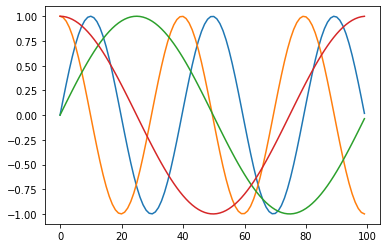

In [11]:
pe = PositionalEncoding(20)
pe.initialize()
X = nd.zeros((1, 100, 20))
Y = pe(X)
_ = plt.plot(np.arange(100), Y.asnumpy()[0, :, 4:8])

## Transformer Encoder

<img src="../img/self-attention.svg" width="33%"/>

Now we define the transformer block for the encoder, which contains a multi-head attention layer, a position-wise feed-forward network, and two connection blocks.

Due to the residual connections, this block will not change the input shape. It means the `units` argument should be equal to the input's last dimension size.

The encoder stacks $n$ blocks. Due to the residual connection again, the embedding layer size $d$ is same as the transformer block output size. Also note that we multiple the embedding output by $\sqrt{d}$ to avoid its values are too small compared to positional encodings.

In [12]:
class EncoderBlock(nn.Block):
    def __init__(self, units, hidden_size, num_heads, dropout, **kwargs):
        super().__init__(**kwargs)
        self.attention = MultiHeadAttention(units, num_heads, dropout)
        self.add_1 = AddNorm(dropout)
        self.ffn = PositionWiseFFN(units, hidden_size)
        self.add_2 = AddNorm(dropout)
        
    def forward(self, X, mask):
        Y = self.add_1(X, self.attention(X, X, X, mask))
        return self.add_2(Y, self.ffn(Y))
    
class TransformerEncoder(nn.Block):
    def __init__(self, vocab_size, units, hidden_size, num_heads, num_layers, dropout, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.embed = nn.Embedding(vocab_size, units)
        self.pos_encoding = PositionalEncoding(units, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers): self.blks.add(EncoderBlock(units, hidden_size, num_heads, dropout))

    def forward(self, X, mask, *args):
        X = self.pos_encoding(self.embed(X) * math.sqrt(self.units))
        for blk in self.blks: X = blk(X, mask)
        return X
    
encoder = TransformerEncoder(vocab_size=200, units=24, hidden_size=48, num_heads=8, num_layers=2, dropout=0.5)
encoder.initialize()
encoder(nd.ones((2, 3)), mask).shape

(2, 3, 24)

## Transformer-Decoder

<center>
<img src="../img/self-attention-predict.svg" width="50%"/>
</center>

Let first look at how a decoder behaviors during predicting. Similar to the seq2seq model, we call $T$ forwards to generate a $T$ length sequence. At time step $t$, assume $\mathbf x_t$ is the current input, i.e. the query. Then keys and values of the self-attention layer consist of the current query with all past queries $\mathbf x_1, \ldots, \mathbf x_{t-1}$.

During training, because the output for the $t$-query could depend all $T$ key-value pairs, which results in an inconsistent behavior than prediction. We can eliminate it by specifying the valid length to be $t$ for the $t$-th query.

Another difference compared to the encoder transformer block is that the decoder block has an additional multi-head attention layer that accepts the encoder outputs as keys and values.

In [13]:
class DecoderBlock(nn.Block):
    def __init__(self, units, hidden_size, num_heads, dropout, i, **kwargs):
        super().__init__(**kwargs)
        self.i = i  # i means it's the i-th block in the decoder
        self.attn1, self.attn2 = [MultiHeadAttention(units, num_heads, dropout) for _ in range(2)]
        self.addnorm1, self.addnorm2, self.addnorm3 = [AddNorm(dropout) for _ in range(3)]
        self.ffn = PositionWiseFFN(units, hidden_size)

    def forward(self, X, state, dec_mask=None):  # key_values contains the past queries for this block
        enc_outputs, enc_mask, key_values = state
        key_values[self.i] = nd.concat(key_values[self.i], X, dim=1)  # update key_values
        X2 = self.attn1(X, key_values[self.i], key_values[self.i], dec_mask)
        Y = self.addnorm1(X, X2)
        Y2 = self.attn2(Y, enc_outputs, enc_outputs, enc_mask)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), [enc_outputs, enc_mask, key_values]
    
class TransformerDecoder(nn.Block):
    def __init__(self, vocab_size, units, hidden_size, num_heads, num_layers, dropout, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.embed = nn.Embedding(vocab_size, units)
        self.pos_encoding = PositionalEncoding(units, dropout)
        self.blks = [DecoderBlock(units, hidden_size, num_heads, dropout, i) for i in range(num_layers)]
        self.dense = nn.Dense(vocab_size, flatten=False)

    def forward(self, X, state):
        X = self.pos_encoding(self.embed(X) * math.sqrt(self.units))
        for blk in self.blks: X, state = blk(X, state)
        return self.dense(X), state

## Use the Pretrained Transformer model

In [14]:
with mx.np_shape(False):
    wmt_transformer_model, wmt_src_vocab, wmt_tgt_vocab = \
        nlp.model.get_model('transformer_en_de_512',
                            dataset_name='WMT2014',
                            pretrained=True,
                            ctx=ctx)

# This model is based on a mixed EN-DE vocabulary, thus the src and tgt vocabs are of equal size
print('#Source Vocab:', len(wmt_src_vocab), ', #Target Vocab:', len(wmt_tgt_vocab))

wmt_data_test = nlp.data.WMT2014BPE('newstest2014', src_lang='en', tgt_lang='de')
print('Sample BPE tokens:', wmt_data_test[1337])

#Source Vocab: 36794 , #Target Vocab: 36794
Sample BPE tokens: ('At least one h@@ ac@@ ktiv@@ ist group online claimed that they were responsible for bringing down the N@@ SA site with a D@@ Do@@ S attack .', 'Min@@ destens eine Gruppe von H@@ ac@@ kti@@ visten nahm für sich in Anspruch , die N@@ SA@@ -@@ Website mit einem D@@ Do@@ S-@@ Angriff la@@ h@@ m@@ gelegt zu haben .')


In [15]:
print(wmt_transformer_model) # Print the model

NMTModel(
  (encoder): TransformerEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): LayerNorm(eps=1e-05, axis=-1, center=True, scale=True, in_channels=512)
    (transformer_cells): HybridSequential(
      (0): TransformerEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(512 -> 512, linear)
          (proj_key): Dense(512 -> 512, linear)
          (proj_value): Dense(512 -> 512, linear)
        )
        (proj): Dense(512 -> 512, linear)
        (ffn): PositionwiseFFN(
          (ffn_1): Dense(512 -> 2048, linear)
          (activation): Activation(relu)
          (ffn_2): Dense(2048 -> 512, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): LayerNorm(eps=1e-05, axis=-1, center=True, scale=True, in_channels=512)
        )


### Translation Example

In [16]:
from gluonnlp.model import BeamSearchScorer, BeamSearchSampler
import nmt

def decode_logprob(step_input, states):
    out, states, _ = wmt_transformer_model.decode_step(step_input, states)
    return nd.log_softmax(out), states

sampler = BeamSearchSampler(decoder=decode_logprob, beam_size=4, max_length=200,
    eos_id=wmt_tgt_vocab.token_to_idx[wmt_tgt_vocab.eos_token],
    scorer=nlp.model.BeamSearchScorer(alpha=0.6, K=5))

def translate(src_sentence, bos_idx):
    encoder_outputs, _ = wmt_transformer_model.encode(nd.array([src_sentence], dtype=np.int32, ctx=ctx))
    decoder_states = wmt_transformer_model.decoder.init_state_from_encoder(encoder_outputs)
    samples, scores, valid_length = sampler(nd.array([bos_idx], ctx=ctx, dtype=np.float32), decoder_states)
    return samples[0, 0, :valid_length[0, 0].asscalar()]  # sample with max score

sample_sentence = 'We love natural language processing .'.split() + [wmt_src_vocab.eos_token]
print('Translating English to German:\n', sample_sentence)
sample_src_seq = wmt_src_vocab[sample_sentence]
sample_tgt_seq = translate(sample_src_seq, wmt_tgt_vocab[wmt_tgt_vocab.bos_token])
sample_translation = [wmt_tgt_vocab.idx_to_token[ele] for ele in sample_tgt_seq.asnumpy()]
print('The German translation is:\n', sample_translation)

Translating English to German:
 ['We', 'love', 'natural', 'language', 'processing', '.', '<eos>']
The German translation is:
 ['<bos>', 'Wir', 'lieben', 'die', 'natürliche', 'Sprach@@', 'verarbeitung', '.', '<eos>']


If you'd like to train your own machine translation models, check the GluonNLP [Model Zoo](http://gluon-nlp.mxnet.io/model_zoo/machine_translation/index.html) or the source on Github: [github.com/dmlc/gluon-nlp](https://github.com/dmlc/gluon-nlp/tree/master/scripts/machine_translation)

## References

[1] Vaswani, Ashish, et al. "Attention is all you need." Advances in Neural Information Processing Systems. 2017.